# **Rocket League Win Prediction Model**
## **Author:** Tanner Rapp
### **Data Source:** Monfret, D. (2022). Rocket League Championship Series 2021-2022 [Dataset]. Kaggle. https://www.kaggle.com/datasets/dylanmonfret/rlcs-202122

### About the Dataset
---

This dataset contains detailed statistics from the Rocket League Championship Series (RLCS) 2021–2022 season. It includes match outcomes, player performance metrics, and in-game events such as goals, assists, possession time, and boost usage. The data provides a rich foundation for analyzing gameplay patterns, predicting match results, and evaluating the key factors that contribute to winning in professional Rocket League competition.


### Import Libraries
---

In [112]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim


### Load in the Data
---

In [113]:
data = pd.read_csv(r"C:\Users\tanne\OneDrive\Desktop\Fun Statistical Coding Practice\Rocket League\games_by_teams.csv")
print(data.shape)
data.head()

(35594, 55)


,game_id,color,team_id,team_slug,team_name,team_region,ball_possession_time,ball_time_in_side,core_shots,core_goals,...,positioning_time_defensive_third,positioning_time_neutral_third,positioning_time_offensive_third,positioning_time_defensive_half,positioning_time_offensive_half,positioning_time_behind_ball,positioning_time_in_front_ball,demo_inflicted,demo_taken,winner
0,616004f3143c37878b238690,blue,6020bc8ef1e4807cc700391a,https://octane.gg/teams/391a-ground-zero-gaming,GROUND ZERO GAMING,Oceania,136.54,170.84,13,2,...,513.73,291.06,189.48,660.06,334.20,727.07,267.20,1.0,3.0,True
1,616004f3143c37878b238690,orange,614c8930f8090ec745286474,https://octane.gg/teams/6474-ranga-roundup,RANGA ROUNDUP,Oceania,153.60,148.51,4,1,...,457.04,329.25,214.03,633.39,366.93,740.69,259.64,3.0,1.0,False
2,616004f7143c37878b238697,blue,6020bc8ef1e4807cc700391a,https://octane.gg/teams/391a-ground-zero-gaming,GROUND ZERO GAMING,Oceania,155.79,145.60,10,4,...,507.95,308.51,264.92,659.74,421.65,780.01,301.38,5.0,1.0,True
3,616004f7143c37878b238697,orange,614c8930f8090ec745286474,https://octane.gg/teams/6474-ranga-roundup,RANGA ROUNDUP,Oceania,126.81,185.78,6,2,...,561.51,360.96,147.48,762.21,307.73,782.32,287.61,1.0,5.0,False
4,616004fc143c37878b23869e,blue,6020bc8ef1e4807cc700391a,https://octane.gg/teams/391a-ground-zero-gaming,GROUND ZERO GAMING,Oceania,165.76,136.11,11,3,...,476.66,373.66,279.05,648.19,481.20,832.70,296.69,0.0,3.0,True


### Data Prep
---

In [114]:
data.columns

Index(['game_id', 'color', 'team_id', 'team_slug', 'team_name', 'team_region',
       'ball_possession_time', 'ball_time_in_side', 'core_shots', 'core_goals',
       'core_saves', 'core_assists', 'core_score', 'core_shooting_percentage',
       'boost_bpm', 'boost_bcpm', 'boost_avg_amount', 'boost_amount_collected',
       'boost_amount_stolen', 'boost_amount_collected_big',
       'boost_amount_stolen_big', 'boost_amount_collected_small',
       'boost_amount_stolen_small', 'boost_count_collected_big',
       'boost_count_stolen_big', 'boost_count_collected_small',
       'boost_count_stolen_small', 'boost_amount_overfill',
       'boost_amount_overfill_stolen', 'boost_amount_used_while_supersonic',
       'boost_time_zero_boost', 'boost_time_full_boost',
       'boost_time_boost_0_25', 'boost_time_boost_25_50',
       'boost_time_boost_50_75', 'boost_time_boost_75_100',
       'movement_total_distance', 'movement_time_supersonic_speed',
       'movement_time_boost_speed', 'movement_t

In [115]:
# Drop unnecessary variables
data = data.drop(columns=['color','team_slug', 'team_name','team_region'])

In [116]:
# Remove missing values
data = data.dropna()

In [117]:
# Take the average by game_id and team_id (It is a team sport after all)
data = data.groupby(['game_id','team_id'], as_index=False).mean()
data = data.drop(columns=['team_id','game_id'])

In [118]:
# Split into training/test/validation data
x_data = data.drop(columns=['winner'])
y_data = data['winner']

x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.2, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1)

In [120]:
# Standardize
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test= scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

In [121]:
# Convert to tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1, 1)
y_val  = torch.tensor(y_val .values,  dtype=torch.float32).view(-1, 1)

### Model Architecture

---

In [122]:
# Define Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.Linear = nn.Linear(input_dim,1) # Binary output 

    def forward(self, x):
        x = torch.sigmoid(self.Linear(x))
        return x

input_dim = x_train.shape[1]

model = LogisticRegressionModel(input_dim)

criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01)

### Train Model
---

In [123]:
# Define training loop
epochs = 20000

for epoch in range(1, epochs + 1):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 1000 ==0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f}")


# Evaluation phase on test set
model.eval()
with torch.no_grad():
    # Train preds
    train_probs = model(x_train)             # [N,1] in [0,1]
    train_preds = (train_probs >= 0.5).float()
    train_acc = (train_preds.eq(y_train).float().mean().item())

    # Test preds
    test_probs = model(x_test)
    test_preds = (test_probs >= 0.5).float()
    test_acc = (test_preds.eq(y_test).float().mean().item())

     # Validation preds
    val_probs = model(x_val)
    val_preds = (val_probs >= 0.5).float()
    val_acc = (val_preds.eq(y_val).float().mean().item())


print(f"\nTrain Accuracy: {train_acc*100:.2f}%")
print(f"\n    Test Accuracy: {test_acc*100:.2f}%")
print(f"\n          Validation Accuracy: {val_acc*100:.2f}%")
    

Epoch 1000 | Loss: 0.304307
Epoch 2000 | Loss: 0.266703
Epoch 3000 | Loss: 0.246734
Epoch 4000 | Loss: 0.233514
Epoch 5000 | Loss: 0.223794
Epoch 6000 | Loss: 0.216182
Epoch 7000 | Loss: 0.209965
Epoch 8000 | Loss: 0.204736
Epoch 9000 | Loss: 0.200240
Epoch 10000 | Loss: 0.196309
Epoch 11000 | Loss: 0.192827
Epoch 12000 | Loss: 0.189707
Epoch 13000 | Loss: 0.186889
Epoch 14000 | Loss: 0.184322
Epoch 15000 | Loss: 0.181969
Epoch 16000 | Loss: 0.179801
Epoch 17000 | Loss: 0.177793
Epoch 18000 | Loss: 0.175924
Epoch 19000 | Loss: 0.174178
Epoch 20000 | Loss: 0.172543

Train Accuracy: 93.32%

    Test Accuracy: 93.49%

          Validation Accuracy: 93.31%


### Visualize Performance
---

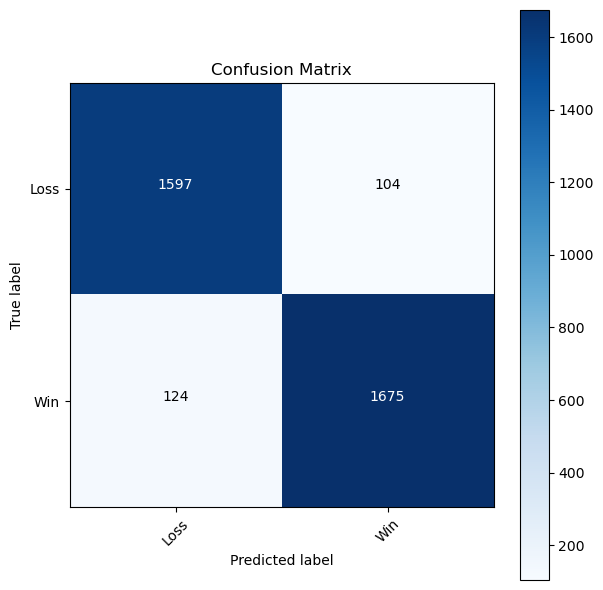

Classification Report:
               precision    recall  f1-score   support

        Loss       0.93      0.94      0.93      1701
         Win       0.94      0.93      0.94      1799

    accuracy                           0.93      3500
   macro avg       0.93      0.93      0.93      3500
weighted avg       0.93      0.93      0.93      3500



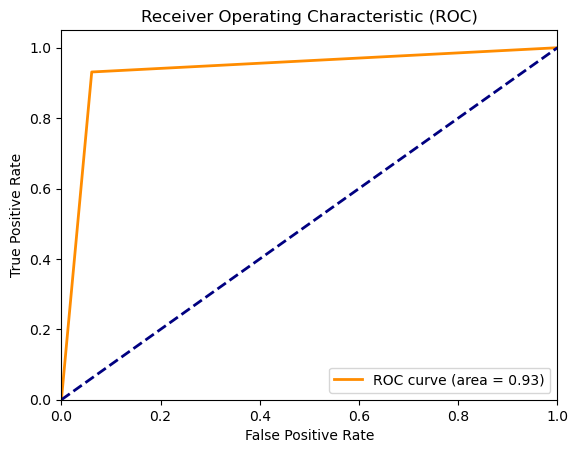

In [124]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

# Visualize the confusion matrix
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test, test_preds, target_names=['Loss', 'Win']))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


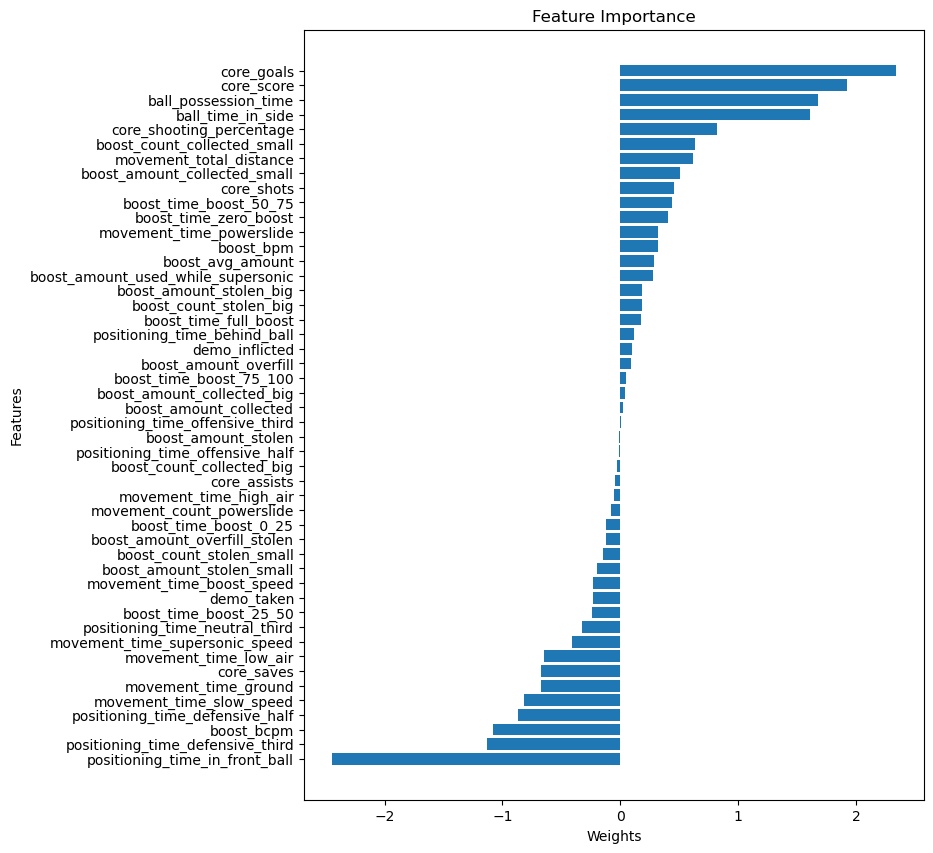

In [131]:
# Extract the weights of the linear layer
weights = model.Linear.weight.data.numpy().flatten()

# Create a DataFrame for feature importance
features_df = pd.DataFrame({
    "Feature":x_data.columns,
    "Weights":weights}).sort_values(by="Weights", ascending = False)

# Plot 
plt.figure(figsize=(8, 10))  
plt.barh(features_df['Feature'], features_df['Weights'])
plt.ylabel('Features')
plt.xlabel('Weights')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

### Summary
---

This set of results shows that the model performs very well at predicting Rocket League match outcomes.

- Confusion Matrix: Out of 3,500 matches, the model correctly predicted 1,597 losses and 1,675 wins, with only around 200 total misclassifications.

- Classification Report: Both classes (Win and Loss) have nearly identical performance, with precision and recall around 93–94%, showing no bias toward one outcome.

- ROC Curve (AUC = 0.93): The model is highly discriminative, meaning it can reliably separate wins from losses far better than random guessing.

The above plot shows the feature importance values from a Rocket League dataset I analyzed. Positive weights (to the right) indicate features that push predictions toward winning, while negative weights (to the left) are more associated with losing. Goals, score, ball possession, and shooting percentage stand out as the strongest predictors of winning outcomes, while defensive positioning and time spent away from the ball lean toward losses. Overall, it highlights which gameplay metrics matter most for predicting match results.

#### -**Helps chances of winning**-
- **Core Goals:** Goals
- **Core Score:** Sum of players scores
- **Ball Possession Time:** Time spent with ball possession
- **Ball Time In Side:** Time spent with ball on team side

#### -**Hurts chances of winning**-
- **Positioning Time Defensive Half:** Time spent in defensive half
- **Boost BCPM:** Boost consumed per minute
- **Positioning Time Defensive Third:** Time spent in defensive third
- **Positioning Time in Front Ball:** Time spent in front of the ball